## **1.Importing Environment**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import plotly.express as px
import os
import plotly.offline as og
import plotly.express as px
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, precision_recall_curve, roc_curve, f1_score
from sklearn.model_selection import GroupKFold, cross_validate, GridSearchCV, validation_curve
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## **1.1 Importing the Pre-processed data from UCI HAR dataset [1]**

In [0]:
PATH = "/content/drive/My Drive/UCI HAR Dataset/"


train_data = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/train/X_train.txt", delimiter= '\s+', header=None)
train_labels = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/train/y_train.txt", delimiter= '\s+', header=None)


test_data = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/test/X_test.txt", delimiter= '\s+', header=None)
test_labels = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/test/y_test.txt", delimiter= '\s+', header=None)


colnames=['subject_id'] 
subject_train = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/train/subject_train.txt", delimiter= '\s+', header=None, names=colnames)
subject_test = pd.read_csv("/content/drive/My Drive/UCI HAR Dataset/test/subject_test.txt", delimiter= '\s+', header=None, names=colnames)


colnames = ['activity_id','activity_name']
activity_labels = pd.read_csv(r"/content/drive/My Drive/UCI HAR Dataset/activity_labels.txt", delimiter= '\s+', header=None, names=colnames)


colnames = ['id', 'feature_name']
features = pd.read_csv(r"/content/drive/My Drive/UCI HAR Dataset/features.txt", delimiter= '\s+', header=None, names=colnames)



### Assigning the column names of train and test data with their corresponding feature names

In [0]:
train_data.columns = features.feature_name
test_data.columns = features.feature_name

## **1.2 Analysis of the Data**

In [8]:
# Subject ID's available for training the model

print ("Subject Id's for Training {}".format(subject_train.subject_id.unique()))
print ("Subject Id's for Testing {}".format(subject_test.subject_id.unique()))

Subject Id's for Training [ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
Subject Id's for Testing [ 2  4  9 10 12 13 18 20 24]


In [0]:
data_train_all = train_data.copy()
data_test_all = test_data.copy()

data_train_all["subject_id"] = subject_train.subject_id
data_train_all["activity_id"] = train_labels

data_test_all["subject_id"] = subject_test.subject_id
data_test_all["activity_id"] = test_labels

data_train_all["activity_label"] =  ""
for id in activity_labels.activity_id.unique():
    data_train_all.loc[data_train_all.activity_id == id, "activity_label"] = activity_labels.loc[activity_labels.activity_id == id].activity_name.iloc[0]

data_test_all["activity_label"] = ""
for id in activity_labels.activity_id.unique():
    data_test_all.loc[data_test_all.activity_id == id, "activity_label"]  = activity_labels.loc[activity_labels.activity_id == id].activity_name.iloc[0]


data_train_all["type"] = "Train"
data_test_all["type"] = "Test"

data_all = pd.concat([data_train_all, data_test_all])
data_train_all = data_train_all.drop(columns="type")
data_test_all = data_test_all.drop(columns="type")

### Total distribution of activities available for Training and Testing

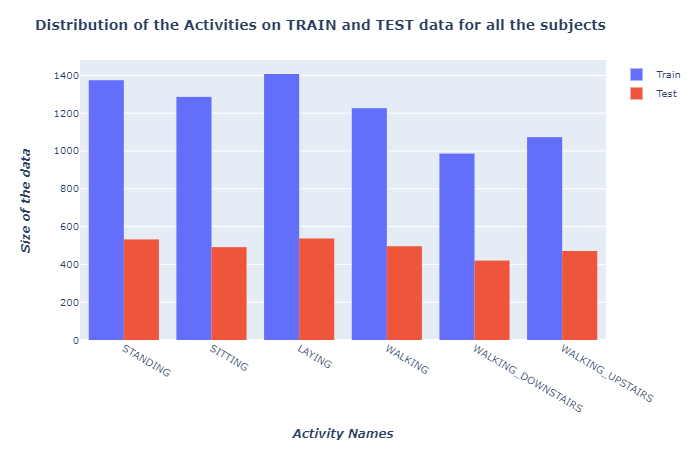

In [0]:
fig = px.histogram(data_all, x = 'activity_label', barmode='group', color="type"
                   )

fig.update_layout(
    title = '<b>Distribution of the Activities on TRAIN and TEST data for all the subjects</b>',
    xaxis_title="<b><i>Activity Names</i></b>",
    yaxis_title="<b><i>Size of the data</i></b>",
    font=dict(
        size=10
    ))
for trace in fig.data:
    trace.name = trace.name.split('=')[1]
    
fig.show("png")
    
# Image(fig.to_image(format="png", scale=3))

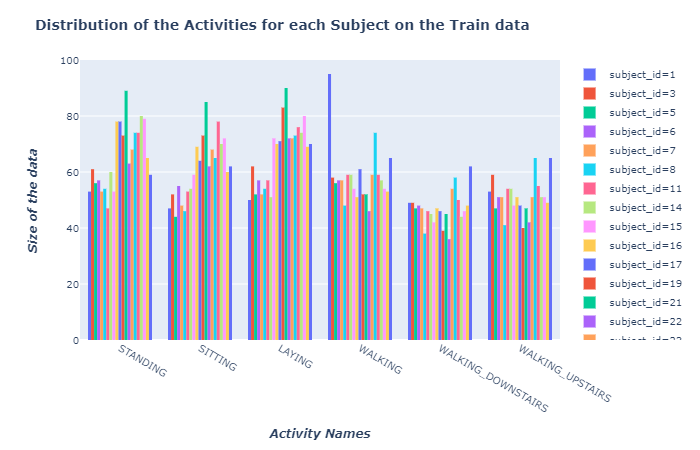

In [0]:
fig = px.histogram(data_train_all, x = 'activity_label', barmode='group',
                   color='subject_id'
                   )

fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    title = '<b>Distribution of the Activities for each Subject on the Train data</b>',
    xaxis_title="<b><i>Activity Names</i></b>",
    yaxis_title="<b><i>Size of the data</i></b>",
    font=dict(
        size=10
    )
)

fig.show("png")


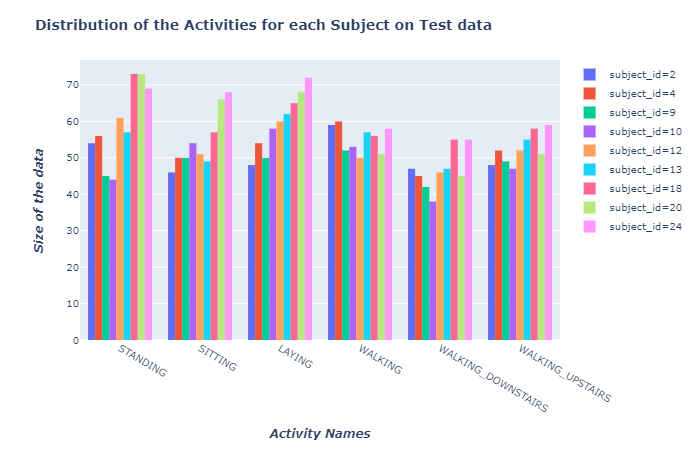

In [0]:
fig = px.histogram(data_test_all, x = 'activity_label', barmode='group',
                   color='subject_id'
                   )

fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    title = '<b>Distribution of the Activities for each Subject on Test data</b>',
    xaxis_title="<b><i>Activity Names</i></b>",
    yaxis_title="<b><i>Size of the data</i></b>",
    font=dict(
        size=10
    )
)

fig.show("png")

In [0]:
X_train = train_data
X_test = test_data

y_train = train_labels
y_test = test_labels

## 2 **Training the model with SVM One vs Rest** [13]

#### **2.1   Using Traditional Train-test split**



In [44]:
clf_traditional = OneVsRestClassifier(SVC(kernel='rbf', C=1,  gamma=0.01, probability=True)).fit(X_train, y_train)
pred_svc_traditional = clf_traditional.predict(X_test)
print (classification_report(y_test, pred_svc_traditional))

accuracy_svm = classification_report(y_test, pred_svc_traditional, output_dict=True)["accuracy"]
print ("The total accuracy is {}".format(accuracy_svm))

              precision    recall  f1-score   support

           1       0.96      0.98      0.97       496
           2       0.93      0.97      0.95       471
           3       0.99      0.93      0.96       420
           4       0.94      0.90      0.92       491
           5       0.91      0.95      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947

The total accuracy is 0.9541907024092298


In [45]:
svm_traditional_prob = clf_traditional.predict_proba(X_test)
svm_traditional_prob

array([[3.16264943e-07, 5.12123828e-05, 7.79741908e-05, 2.44975404e-04,
        9.99500323e-01, 1.25198759e-04],
       [1.04577542e-07, 7.31414879e-06, 3.88502935e-06, 1.29778602e-02,
        9.86992766e-01, 1.80702178e-05],
       [3.07386986e-07, 2.71939016e-07, 3.49927979e-05, 2.03432171e-03,
        9.97926684e-01, 3.42252576e-06],
       ...,
       [5.04887700e-04, 9.99185276e-01, 1.89114606e-05, 6.36595713e-05,
        1.37976501e-04, 8.92887227e-05],
       [2.48119217e-03, 9.96653501e-01, 4.89493012e-05, 6.96535506e-04,
        6.38415310e-05, 5.59800794e-05],
       [3.18693182e-01, 6.80256599e-01, 6.90617819e-05, 3.96983348e-04,
        3.80791749e-04, 2.03381952e-04]])

### ROC curve and Precision-Recall curve [14] [15]

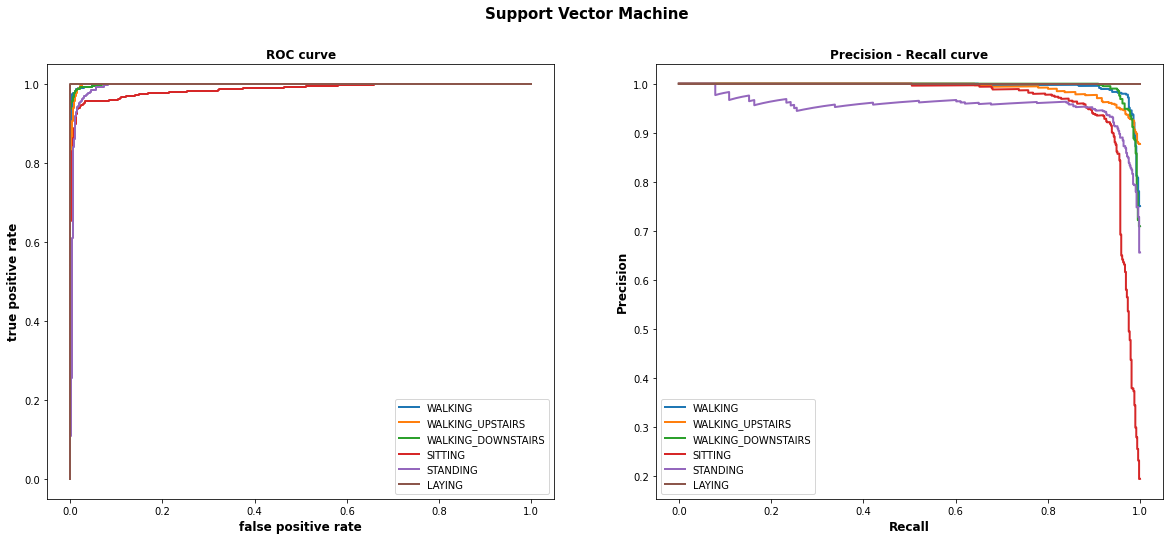

In [64]:
fpr = dict()
tpr = dict()

precision = dict()
recall = dict()

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(pd.get_dummies(test_labels[0]).values[:, i], svm_traditional_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve", fontweight='bold')

plt.subplot(1,2,2)
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(test_labels[0]).values[:, i], svm_traditional_prob[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision - Recall curve", fontweight='bold')

plt.suptitle("Support Vector Machine", fontsize=15, fontweight='bold')
plt.show()

### **2.2 Using Grouped Cross Validation (Subject level CV)**

##### The grouping based on different participants can be done to train and validate the model against the data from unseen participant (Subject) so that the generalization capability of the model can be evaluated.
[3][4] [16]

In [6]:
nTrainingSubjects = len(subject_train.subject_id.unique())
groups = subject_train.subject_id


param_grid = {"estimator__C": [1, 10],        
              "estimator__kernel" : ["linear", "rbf"]
              #"estimator__gamma": [1,0.1]
             }

gkf = GroupKFold(n_splits = nTrainingSubjects)
grouped_cv = gkf.split(X_train, y_train, groups=groups)

clf_cross_validated = GridSearchCV(OneVsRestClassifier(SVC(probability=True)),param_grid, refit=True,verbose=2, cv = grouped_cv, scoring="accuracy", return_train_score=True)
cross_validated_SVM_result = clf_cross_validated.fit(X_train, y_train.values)

Fitting 21 folds for each of 4 candidates, totalling 84 fits
[CV] estimator__C=1, estimator__kernel=linear ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... estimator__C=1, estimator__kernel=linear, total=  45.1s
[CV] estimator__C=1, estimator__kernel=linear ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s remaining:    0.0s


[CV] ......... estimator__C=1, estimator__kernel=linear, total=  44.5s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  45.9s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  46.2s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  44.5s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  46.8s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  45.6s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] ......... estimator__C=1, estimator__kernel=linear, total=  45.7s
[CV] estimator__C=1, estimator__kernel=linear ........................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 114.4min finished


In [7]:
cross_validated_SVM_result.best_estimator_

OneVsRestClassifier(estimator=SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [8]:
cv_prediction_svm = cross_validated_SVM_result.predict(X_test)
print (classification_report(y_test, cv_prediction_svm))
accuracy_svm_cv = classification_report(y_test, cv_prediction_svm, output_dict=True)["accuracy"]
print ("The total accuracy is {}".format(accuracy_svm_cv))

              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.96      0.97      0.96       471
           3       1.00      0.96      0.98       420
           4       0.98      0.89      0.93       491
           5       0.91      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.97      0.96      0.96      2947

The total accuracy is 0.9647098744485918


In [9]:
cv_svm_results_df = pd.concat([pd.DataFrame(cross_validated_SVM_result.cv_results_["params"]),
           pd.DataFrame(cross_validated_SVM_result.cv_results_["mean_train_score"],columns=["mean_train_score"]), pd.DataFrame(cross_validated_SVM_result.cv_results_["mean_test_score"],columns=["mean_test_score"]),
          pd.DataFrame(cross_validated_SVM_result.cv_results_["std_train_score"],columns=["std_train_score"]), pd.DataFrame(cross_validated_SVM_result.cv_results_["std_test_score"],columns=["std_test_score"])],
          axis=1)

cv_svm_results_df

,estimator__C,estimator__kernel,mean_train_score,mean_test_score,std_train_score,std_test_score
0,1,linear,0.993982,0.940474,0.000909,0.072700
1,1,rbf,0.978216,0.939081,0.001159,0.063323
2,10,linear,0.996906,0.935198,0.000749,0.075373
3,10,rbf,0.994035,0.949807,0.000731,0.057732


### ROC and Precision-Recall Curve

In [10]:
svm_cv_prob = cross_validated_SVM_result.predict_proba(X_test)
svm_cv_prob

array([[9.99573828e-08, 3.41059761e-06, 1.03143155e-04, 7.45585968e-05,
        9.99573721e-01, 2.45066480e-04],
       [9.94533984e-08, 1.32675164e-07, 3.10790925e-07, 1.03539435e-02,
        9.89625278e-01, 2.02358024e-05],
       [1.00050032e-07, 1.00050032e-07, 3.89821214e-06, 3.86167916e-03,
        9.96131266e-01, 2.95664278e-06],
       ...,
       [1.40618791e-04, 9.99707731e-01, 9.00336400e-06, 9.47783603e-06,
        7.95756921e-06, 1.25210951e-04],
       [4.68913255e-04, 9.99253661e-01, 4.52350545e-05, 1.65041142e-04,
        2.38490850e-06, 6.47646587e-05],
       [3.34045822e-02, 9.66439521e-01, 3.78748876e-05, 2.07126810e-05,
        1.97880267e-05, 7.75207666e-05]])

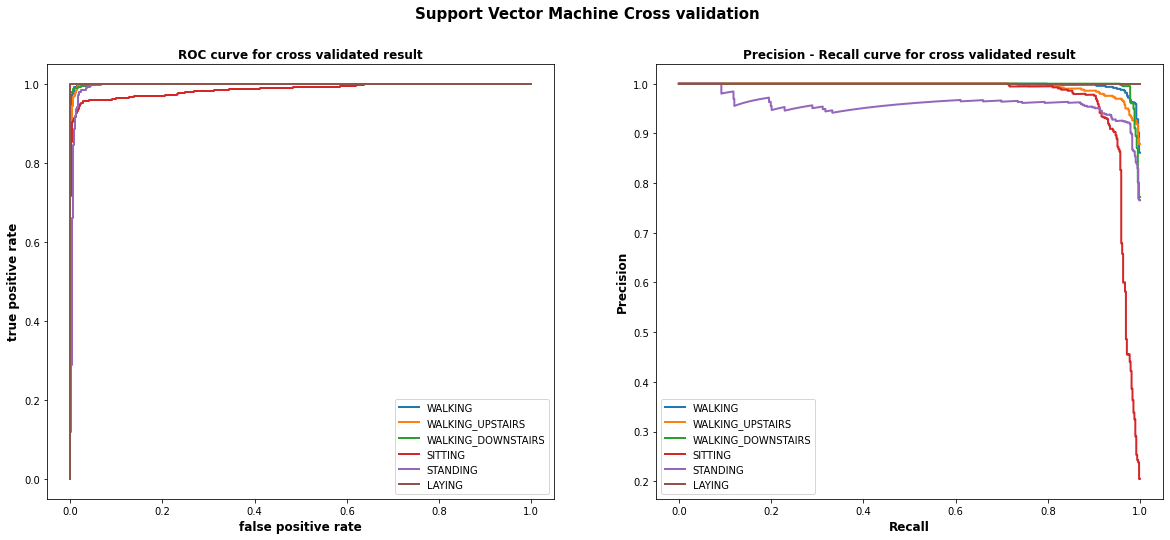

In [65]:
fpr = dict()
tpr = dict()

precision = dict()
recall = dict()

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(pd.get_dummies(test_labels[0]).values[:, i], svm_cv_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve for cross validated result", fontweight='bold')

plt.subplot(1,2,2)
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(test_labels[0]).values[:, i], svm_cv_prob[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision - Recall curve for cross validated result", fontweight='bold')
plt.suptitle("Support Vector Machine Cross validation", fontsize=15, fontweight='bold')
plt.show()

## **3 Classification prediction using Random Forest model** [12]

### **3.1 Using Simple Train-test split method**

In [13]:
clf_randforest=RandomForestClassifier(n_estimators=100)
clf_randforest.fit(X_train,y_train.values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
random_forest_predicted = clf_randforest.predict(X_test)
random_forest_predicted

array([5, 5, 5, ..., 2, 2, 1])

In [16]:
print (classification_report(y_test, random_forest_predicted))
accuracy_randforest = classification_report(y_test, random_forest_predicted, output_dict=True)["accuracy"]
print ("The total accuracy is {}".format(accuracy_randforest))

              precision    recall  f1-score   support

           1       0.89      0.97      0.93       496
           2       0.90      0.91      0.90       471
           3       0.96      0.84      0.90       420
           4       0.90      0.90      0.90       491
           5       0.90      0.91      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947

The total accuracy is 0.9243298269426535


In [49]:
randforest_traditional_prob = clf_randforest.predict_proba(X_test)
randforest_traditional_prob


array([[0.  , 0.  , 0.  , 0.13, 0.86, 0.01],
       [0.  , 0.  , 0.  , 0.13, 0.87, 0.  ],
       [0.  , 0.  , 0.  , 0.16, 0.84, 0.  ],
       ...,
       [0.26, 0.68, 0.06, 0.  , 0.  , 0.  ],
       [0.36, 0.46, 0.18, 0.  , 0.  , 0.  ],
       [0.45, 0.39, 0.16, 0.  , 0.  , 0.  ]])

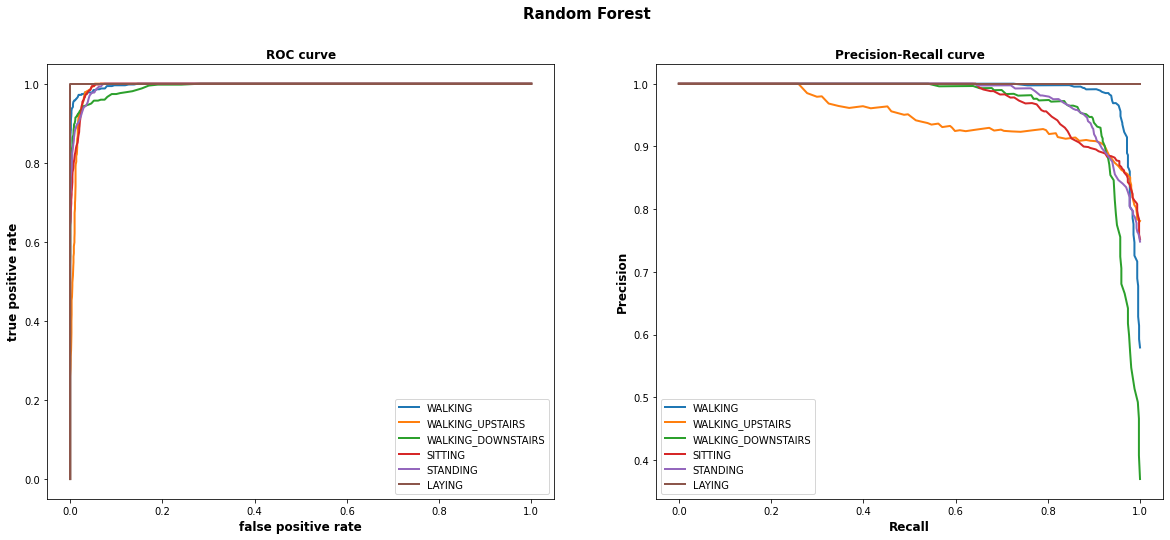

In [67]:
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()


plt.figure(figsize=(20, 8))
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12

plt.subplot(1,2,1)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(pd.get_dummies(test_labels[0]).values[:, i], randforest_traditional_prob[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve", fontweight='bold')


plt.subplot(1,2,2)

for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(test_labels[0]).values[:, i], randforest_traditional_prob[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve", fontweight='bold')
    
plt.suptitle("Random Forest", fontsize=15, fontweight='bold')

plt.show()



### It can be seen that the area under the curve for ROC curve is more (the true positive rate can ve achieved close to 0.9 with almost no false postive rate).
### 

### **3.2 Using Grouped cross validation**

In [21]:
nTrainingSubjects = len(subject_train.subject_id.unique())
groups = subject_train.subject_id


param_grid = {"n_estimators": [60, 100, 150],      
              "criterion" : ["gini", "entropy"]
             }

gkf_randforest = GroupKFold(n_splits = nTrainingSubjects)
grouped_cv_randforest = gkf_randforest.split(X_train, y_train, groups=groups)

clf_cross_validated_randforest = GridSearchCV(RandomForestClassifier(),param_grid, refit=True,verbose=2, cv = grouped_cv_randforest, scoring="accuracy", return_train_score=True)
cross_validated_randforest_result = clf_cross_validated_randforest.fit(X_train, y_train.values)

Fitting 21 folds for each of 6 candidates, totalling 126 fits
[CV] criterion=gini, n_estimators=60 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.0s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.0s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.1s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.2s
[CV] criterion=gini, n_estimators=60 .................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .................. criterion=gini, n_estimators=60, total=   6.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.1s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.1s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.1s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.1s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.2s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.4s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.4s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.7s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.3s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.4s
[CV] criterion=gini, n_estimators=100 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=100, total=  10.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.5s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.1s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.3s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.2s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.6s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.3s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.3s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.5s
[CV] criterion=gini, n_estimators=150 ................................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ................. criterion=gini, n_estimators=150, total=  15.4s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.3s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  14.5s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.4s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.6s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.3s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.5s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.4s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.4s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.4s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.2s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.6s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.7s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.6s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.8s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.5s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.3s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.7s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.7s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.6s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.6s
[CV] criterion=entropy, n_estimators=60 ..............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] ............... criterion=entropy, n_estimators=60, total=  11.5s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  18.8s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  18.9s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.3s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.3s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  18.8s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.5s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.3s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.1s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.2s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.1s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.2s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.6s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.3s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.4s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.2s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.2s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.5s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.6s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.0s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  23.0s
[CV] criterion=entropy, n_estimators=100 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=100, total=  19.3s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.3s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.6s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.9s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.1s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.0s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.2s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.9s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.8s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.3s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.5s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.7s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.9s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.6s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.0s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.8s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.0s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.9s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.9s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  28.8s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.0s
[CV] criterion=entropy, n_estimators=150 .............................


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[CV] .............. criterion=entropy, n_estimators=150, total=  29.1s


[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed: 32.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [23]:
cv_prediction_randforest = cross_validated_randforest_result.predict(X_test)
print (classification_report(y_test, cv_prediction_randforest))
accuracy_randforest_cv = classification_report(y_test, cv_prediction_randforest, output_dict=True)["accuracy"]
print ("The total accuracy is {}".format(accuracy_randforest_cv))

              precision    recall  f1-score   support

           1       0.90      0.97      0.93       496
           2       0.89      0.92      0.90       471
           3       0.97      0.84      0.90       420
           4       0.93      0.88      0.90       491
           5       0.89      0.94      0.92       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947

The total accuracy is 0.9273837801153716


In [24]:
cv_ranforest_results_df = pd.concat([pd.DataFrame(cross_validated_randforest_result.cv_results_["params"]),
           pd.DataFrame(cross_validated_randforest_result.cv_results_["mean_train_score"],columns=["mean_train_score"]), pd.DataFrame(cross_validated_randforest_result.cv_results_["mean_test_score"],columns=["mean_test_score"]),
          pd.DataFrame(cross_validated_randforest_result.cv_results_["std_train_score"],columns=["std_train_score"]), pd.DataFrame(cross_validated_randforest_result.cv_results_["std_test_score"],columns=["std_test_score"])],
          axis=1)

cv_ranforest_results_df

,criterion,n_estimators,mean_train_score,mean_test_score,std_train_score,std_test_score
0,gini,60,1.0,0.910152,0.0,0.082646
1,gini,100,1.0,0.910399,0.0,0.081540
2,gini,150,1.0,0.914290,0.0,0.079856
3,entropy,60,1.0,0.919747,0.0,0.067601
4,entropy,100,1.0,0.920962,0.0,0.067387
5,entropy,150,1.0,0.922876,0.0,0.065051


In [25]:
f1_score(y_test,cv_prediction_randforest, average="macro" )

0.9253755712846202

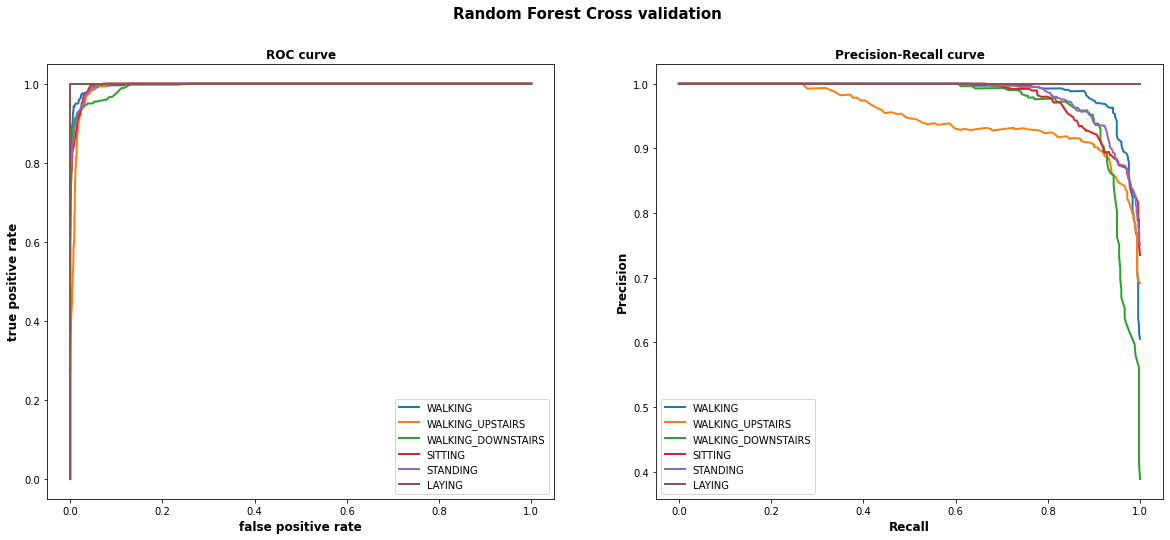

In [68]:
randforest_prob_cv = cross_validated_randforest_result.predict_proba(X_test)

fpr = dict()
tpr = dict()
precision = dict()
recall = dict()


plt.figure(figsize=(20, 8))
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12

plt.subplot(1,2,1)
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(pd.get_dummies(test_labels[0]).values[:, i], randforest_prob_cv[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve", fontweight='bold')


plt.subplot(1,2,2)

for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(pd.get_dummies(test_labels[0]).values[:, i], randforest_prob_cv[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(activity_labels.iloc[i].activity_name))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve", fontweight='bold')
    
plt.suptitle("Random Forest Cross validation", fontsize=15, fontweight='bold')

plt.show()



### It can be seen that the area under the curve for ROC curve is more (the true positive rate can ve achieved close to 0.9 with almost no false postive rate).
### 

## **4. Confusion Matrix plot for the generated models**
(a) SVM model with Train test split

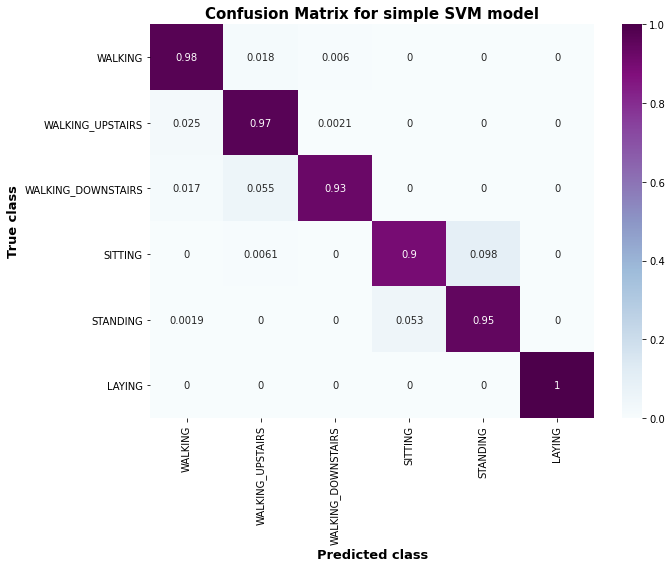

In [89]:
plt.figure(figsize = (10,8))

labels = activity_labels.activity_name.values.tolist()
conf_matrix_2 = confusion_matrix(y_true = y_test.values, y_pred = pred_svc_traditional,  normalize='true')
sn.heatmap(conf_matrix_2, annot=True, xticklabels=labels, yticklabels=labels, cmap="BuPu")
plt.title("Confusion Matrix for simple SVM model", fontsize=15, fontweight="bold")
plt.ylabel("True class", fontsize=13)
plt.xlabel("Predicted class", fontsize=13)
plt.tight_layout()
plt.show()

(b) SVM model with grouped cross validation

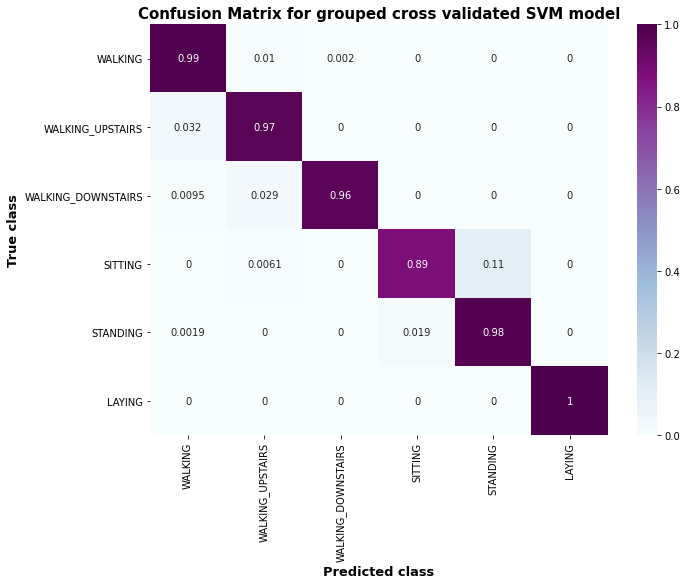

In [90]:
plt.figure(figsize = (10,8))

labels = activity_labels.activity_name.values.tolist()
conf_matrix_1 = confusion_matrix(y_true = y_test.values, y_pred = cv_prediction_svm, normalize='true')
plt.title("Confusion Matrix for grouped cross validated SVM model", fontsize=15, fontweight="bold")
sn.heatmap(conf_matrix_1, annot=True, xticklabels=labels, yticklabels=labels, cmap="BuPu")
plt.tight_layout()
plt.ylabel("True class", fontsize=13)
plt.xlabel("Predicted class", fontsize=13)
plt.show()

(c) Random Forest model with Train test split

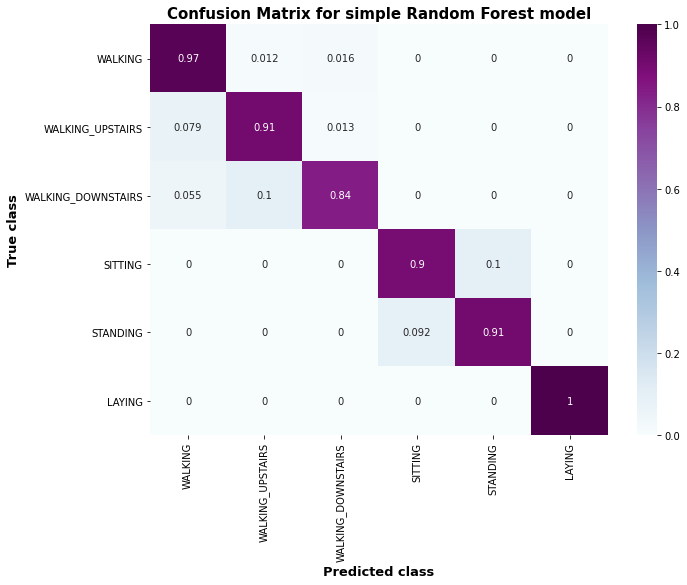

In [91]:
plt.figure(figsize = (10,8))

cnf_random_forest = confusion_matrix(y_true = y_test, y_pred  = random_forest_predicted, normalize="true")

sn.heatmap(cnf_random_forest, annot=True, xticklabels=labels, yticklabels=labels, cmap="BuPu")
plt.title("Confusion Matrix for simple Random Forest model", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.ylabel("True class", fontsize=13)
plt.xlabel("Predicted class", fontsize=13)
plt.show()

(d) Random Forest model with Grouped cross validation

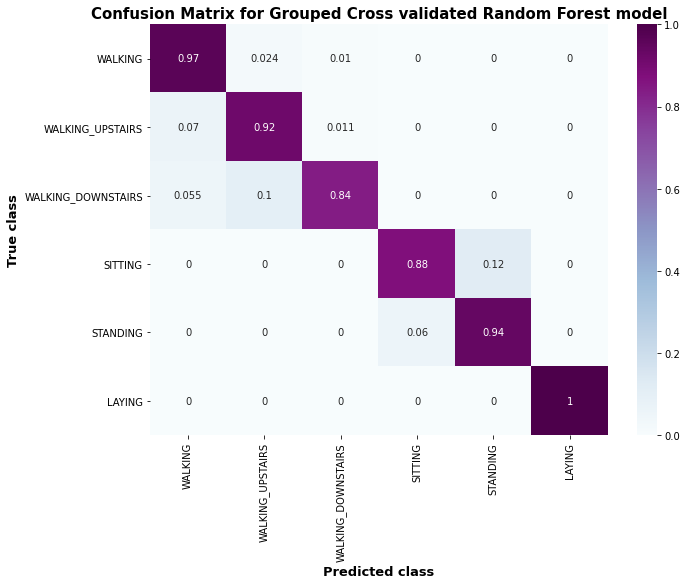

In [92]:
plt.figure(figsize = (10,8))

cnf_cv_random_forest = confusion_matrix(y_true = y_test, y_pred  = cv_prediction_randforest, normalize="true")

sn.heatmap(cnf_cv_random_forest, annot=True, xticklabels=labels, yticklabels=labels, cmap="BuPu")
plt.title("Confusion Matrix for Grouped Cross validated Random Forest model", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.ylabel("True class", fontsize=13)
plt.xlabel("Predicted class", fontsize=13)
plt.show()

## **5. Comparison of prediction results of the two classifers: OVR SVM, Random Forest**

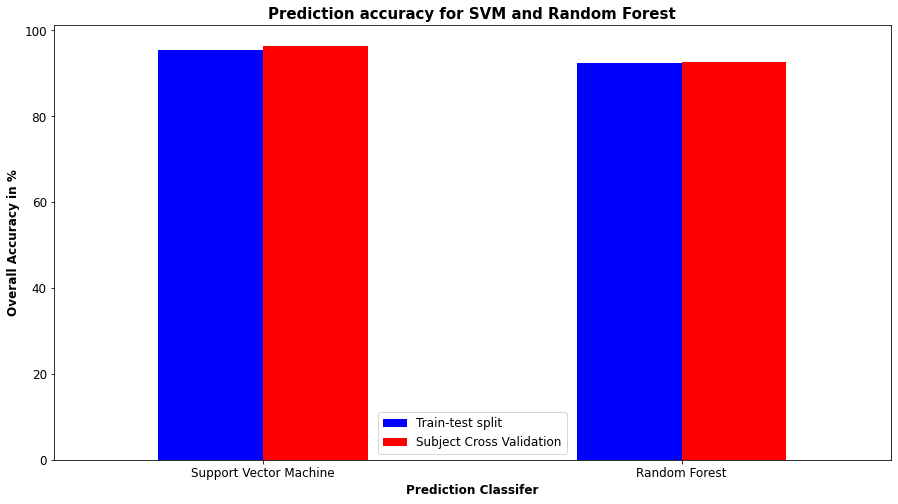

In [88]:
models = ['Support Vector Machine', 'Random Forest']
accuracy_results = [accuracy_svm*100, accuracy_randforest*100]
accuracy_results_cv = [accuracy_svm_cv*100, accuracy_randforest_cv*100]

df = pd.DataFrame(np.c_[accuracy_results,accuracy_results_cv], index=models)
ax = df.plot(kind='bar', rot=0, figsize=(15,8), color=['b', 'r'])
ax.set(xlabel="Prediction Classifer", ylabel="Overall Accuracy in %")
ax.tick_params(labelsize=12)
ax.legend(["Train-test split", "Subject Cross Validation"], fontsize=12)
plt.title("Prediction accuracy for SVM and Random Forest", fontweight="bold", fontsize=15)
plt.show()

## **6. References**

[1] - Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.


[2] https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

[3] https://scikit-learn.org/stable/modules/cross_validation.html

[4] https://arxiv.org/pdf/1904.02666.pdf - Grouped cross validation

[5] https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29 (For Grid search CV)

[10] https://stackoverflow.com/questions/58835592/result-of-gridsearchcv-as-table

[11] https://scikit-learn.org/stable/modules/cross_validation.html#group-cv

[12] L. Xu et al.  “Human activity recognition based on random forests”.  In:2017 13th International-Conference on Natural Computation, Fuzzy Systems and Knowledge Discovery (ICNC-FSKD).2017,pp.  548–553

[13] Davide Anguita et al.  “Human activity recognition on smartphones using a multiclass hardware-friendly support vector machine”. In:International workshop on ambient assisted living. Springer.2012,pp.  216–223

[14] https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

[15] https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

[16] https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier